# Energy and Buildings Paper V3

### Functions
All the subcomponents of the model
* Commerially Available Power Station
* Con Ed Network Data
* PV Performance Modeling
* Grid Electricity Costs
* Hardware Costs
* Max Automated DR Participation

### Loop
Generating all the hardware variations

### Filtering
Filtering hardware variations based on
* ROI

### Analysis

## To Do
* use an average of consumer prices
* add self consumption DC energy for controller to model
* can I prove the battery can always be full at the start of the event???

In [251]:
import pandas as pd
import requests
import pvlib
import matplotlib.pyplot as plt  # for visualization
import math
from datetime import datetime

In [252]:
#GLOBALS

lat = 40.7128
long = -74.0060

#optimize for summer when DR program is in effect
#also minimizes shading from buildings during PSH
tilt = math.floor(lat - 15)

#default to south facing
azimuth = 180

#14% losses
shading = .86

#max 99% efficient mppt battery charger
mppt = .99

#max 80% depth of discharge for LiFePO4 batteries
LiFePOdod = .8

NREL_API_KEY = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'

#Max Hardware Sizes
#500 is an estimate for the largest array someone can relatively easily install without a professional
pvMaxW = 500
#2kWh is the largest system FDNY allows without additional beurocracy 
batMaxWh = 2000

#PV degredation rate is assumed to be 1% annually
DEG_RATE = 0.01

## Commercially Available Power Station Data


In [253]:
# read in hardware data to dataframe
#hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_NOV19.csv')

hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_DEC30.csv')

#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['Link','Battery Type','App Control','Bypass Mode','Min PV Voltage'
                                        , 'Warranty Years','Lifespan'])

priceDate = '(12/30/2023)'#'(11/20/2023)'
priceColumn = 'Retail Price (12/30/2023)'

#filter out batteries over 2kW (this is only needed to increase sample size when looking for representative system)
#print(hardware_df[hardware_df['Battery Wh'] > 2000])
hardware_df = hardware_df[hardware_df['Battery Wh'] <= 2000]

print(hardware_df.shape)
hardware_df.head()

(44, 21)


,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Voltage,Max PV Amps,Inverter Watts,Max AC Input Amps,Max AC Input Watts,...,Inverter Efficiency,Retail Price (11/12/2023),Price per Wh (11/12/2023),Full Price (11/20/2023),Price per Wh (11/20/2023),Retail Price (12/30/2023),Price per Wh (12/30/2023),Unregulated Output,Cycles,DoD
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,27.0,5.0,300,5.0,100.0,...,85.0,254.0,0.88,299.99,1.04,299.99,1.04,False,3000,80
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,60.0,11.0,1000,15.0,1800.0,...,85.0,399.0,0.59,799.00,1.17,799.00,1.17,False,4000,70
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,60.0,22.0,2000,15.0,1800.0,...,85.0,899.0,0.71,1199.00,0.95,1199.00,0.95,False,4000,70
4,Pecron,E600LFP,614.00,400,0.651466,18.0,7.0,1200,NaN,NaN,...,85.0,299.0,0.49,499.00,0.81,299.00,0.49,False,3500,80
5,Pecron,E1500LFP Expandable,1536.00,800,0.520833,18.0,7.0,2200,NaN,NaN,...,85.0,899.0,0.59,1299.00,0.85,899.00,0.59,False,3500,80


In [254]:
#swap NaN in the price column with an earlier retail price for that product if its missing

nanList = list(hardware_df[hardware_df[priceColumn].isnull()].index)

for i in nanList:
    hardware_df.loc[i,priceColumn] = hardware_df.loc[i,'Retail Price (11/12/2023)']

#hardware_df[priceColumn]

In [255]:
# data snapshot
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(hardware_df.shape[0]))

#hardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')
print('')
print('*** Wh ***')
print('Min:' + str(min(hardware_df['Battery Wh'])))
print('Max:' + str(max(hardware_df['Battery Wh'])))
print('Median:' + str(hardware_df['Battery Wh'].median()))

print('')
print('*** W ***')
print('Min:' + str(min(hardware_df['Max PV Watts'])))
print('Max:' + str(max(hardware_df['Max PV Watts'])))
print('Median:' + str(hardware_df['Max PV Watts'].median()))

print('')
print('*** W/Wh ***')
print('Min:' + str(min(hardware_df['W to Wh Ratio'])))
print('Max:' + str(max(hardware_df['W to Wh Ratio'])))
print('Median:' + str(hardware_df['W to Wh Ratio'].median()))

print('')
print('*** Wh/$ ' + priceDate + '***')
print('Min:' + str(min(hardware_df['Price per Wh ' + priceDate])))
print('Max:' + str(max(hardware_df['Price per Wh ' + priceDate])))
print('Median:' + str(hardware_df['Price per Wh ' + priceDate].median()))

print('')
print('*** Cycles ***')
print('Min:' + str(min(hardware_df['Cycles'])))
print('Max:' + str(max(hardware_df['Cycles'])))
print('Median:' + str(hardware_df['Cycles'].median()))

print('')
print('*** Inv Eff ***')
print('Min:' + str(min(hardware_df['Inverter Efficiency'])))
print('Max:' + str(max(hardware_df['Inverter Efficiency'])))
inverterEfficiencyMed = hardware_df['Inverter Efficiency'].median() * .01
print('Median:' + str(inverterEfficiencyMed))



Total Number of Companies: 16
Total Number of Products: 44

*** Wh ***
Min:99.9
Max:2000.0
Median:995.2

*** W ***
Min:40
Max:1200
Median:270.0

*** W/Wh ***
Min:0.1015625
Max:0.8811090226
Median:0.37005070664999995

*** Wh/$ (12/30/2023)***
Min:0.0
Max:1.61
Median:0.74

*** Cycles ***
Min:2000
Max:6000
Median:3100.0

*** Inv Eff ***
Min:85.0
Max:92.0
Median:0.9


## Con Ed Network Data

In [256]:
# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2023-cleaned.csv')

networks_df.head()

,borough,network,start time,end time,tier
0,bronx,central bronx,14:00,18:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,1
4,bronx,southeast bronx,16:00,20:00,2


In [257]:
#returns the network info for a given network
#args: network name
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
#args: network name
def getTierRate(networkName):
    n = getNetworkInfo(networkName)
    t = n['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if t == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
#args: network name
def getBoroughRate(networkName):
    n = getNetworkInfo(networkName)
    t = n['borough'].iloc[0]
    #westchester and staten island pay at a lower rate
    if t not in ['westchester','staten island']:
        return 18
    else:
        return 6

#args: network name
def getTotalRate(networkName):
    return getTierRate(networkName) + getBoroughRate(networkName)
    
#returns borough name
#args: network name
def getBorough(networkName):
    n = getNetworkInfo(networkName)
    return n['borough'].iloc[0]

#returns event start time
#args: network name
def getStartTime(networkName):
    n = getNetworkInfo(networkName)
    return int(n['start time'].iloc[0].split(":")[0])

## PV Performance Modeling

In [258]:
#get TMY via API
df_tmy, metadata = pvlib.iotools.get_psm3(
    latitude=lat, longitude=long,
    api_key=NREL_API_KEY,
    email='nathaa@rpi.edu',  # <-- any email works here fine
    names='tmy-2020')
#metadata

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\pvlib\iotools\psm3.py:364: pvlibDeprecationWarning: PSM3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  'to hide this warning.', pvlibDeprecationWarning)


In [259]:
# make a Location object corresponding to this TMY
location = pvlib.location.Location(name='NYC',
                                   latitude=metadata['Latitude'],
                                   longitude=metadata['Longitude'])

location

Location: 
  name: NYC
  latitude: 40.73
  longitude: -74.02
  altitude: 0
  tz: UTC

In [260]:
#normalize all years to 2022
#remove timezone info #,tzinfo=None
df_tmy.index = df_tmy.index.map(lambda t: t.replace(year=2020))

#uncomment the 30 minute shifts if using data that is right-labeled at hourly intervals!
# Note: TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = df_tmy.index #- pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
#solar_position.index += pd.Timedelta('30min')

solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-01-01 00:30:00-05:00,161.167644,161.167644,-71.167644,-71.167644,22.397593,-3.190860
2020-01-01 01:30:00-05:00,154.001161,154.001161,-64.001161,-64.001161,54.029306,-3.210673
2020-01-01 02:30:00-05:00,143.834623,143.834623,-53.834623,-53.834623,72.365773,-3.230477
2020-01-01 03:30:00-05:00,132.705852,132.705852,-42.705852,-42.705852,84.714658,-3.250272
2020-01-01 04:30:00-05:00,121.355180,121.355180,-31.355180,-31.355180,94.580427,-3.270057
...,...,...,...,...,...,...
2020-12-31 19:30:00-05:00,121.549755,121.549755,-31.549755,-31.549755,265.621718,-3.441097
2020-12-31 20:30:00-05:00,132.896245,132.896245,-42.896245,-42.896245,275.528481,-3.460697
2020-12-31 21:30:00-05:00,144.009842,144.009842,-54.009842,-54.009842,287.965009,-3.480288
2020-12-31 22:30:00-05:00,154.134861,154.134861,-64.134861,-64.134861,306.489310,-3.499870


In [261]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
parameters = all_parameters['open_rack_glass_polymer']

#args: tilt, azimuth
def getPOA(t,a):
    #fixed tilt POA
    df_poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=t,
        surface_azimuth=a,
        dni=df_tmy['DNI'],
        ghi=df_tmy['GHI'],
        dhi=df_tmy['DHI'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        model='isotropic')

    #print(df_poa.keys())
    return df_poa

#DC power going in to battery after accounting for shading and equipment derating
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html#
#args: power, temp coefficient, array nameplate watts
def getPowerYield(p,g,n):
    
    # note the "splat" operator "**" which expands the dictionary "parameters"
    # into a comma separated list of keyword arguments
    cell_temperature = pvlib.temperature.sapm_cell(
        p['poa_global'], df_tmy['Temperature'], df_tmy['Wind Speed'], **parameters)
    
    array_power = pd.DataFrame({
        'power': pvlib.pvsystem.pvwatts_dc(p['poa_global'], cell_temperature, n, g,temp_ref=25.0)
    })

    #yield is actual power going in to battery after losses
    array_power['yield'] = array_power['power'] * shading * mppt
    
    return array_power
    #array_power = pvlib.pvsystem.pvwatts_dc(df_poa['poa_global'], cell_temperature, n, g,temp_ref=25.0)

    #factor in 14% shading losses + 1% mppt losses
    #return array_power * shading * mppt

#convert DC to AC with PV Watts model
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.inverter.pvwatts.html#pvlib.inverter.pvwatts
#args: dc power input, inverter nameplate max AC output, nameplate efficiency
def getACoutput(dcP,maxACW,iE):
    #max dc input required - assuming the nameplate WAC with efficiency accounted for
    dcPMax = maxACW/iE
    #args: dc power input, max dc input capacity, inverter nameplate efficiency
    return pvlib.inverter.pvwatts(dcP, dcPMax,iE)

#returns the degraded power of the array for a given year
#args: PV watts, year, PV degradation rate
def getDegradedP(w,y,dR = DEG_RATE):
    d = 1 - dR
    return w*(d**y)

array_power_yield = getPowerYield(getPOA(tilt,azimuth),gamma_pdc, 500)
array_power_yield.head()

,power,yield
2020-01-01 00:30:00-05:00,0.0,0.0
2020-01-01 01:30:00-05:00,0.0,0.0
2020-01-01 02:30:00-05:00,0.0,0.0
2020-01-01 03:30:00-05:00,0.0,0.0
2020-01-01 04:30:00-05:00,0.0,0.0


In [262]:
print(array_power_yield['power'].max())
print(array_power_yield['yield'].max())
#array_power_yield.iloc[2891]

528.5337668968781
449.993649136002


In [263]:
testW = 1000
print(getACoutput(testW,2000,.9))
print(testW*.9)

901.5865933381758
900.0


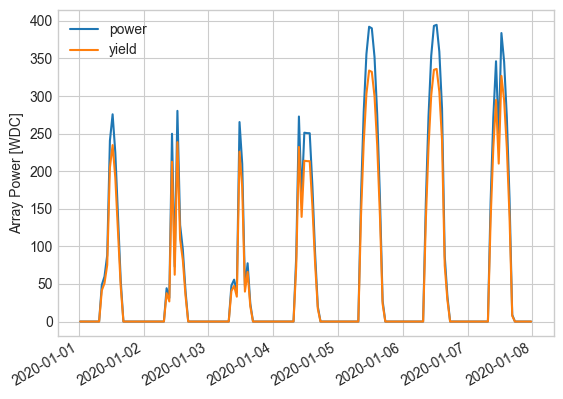

In [264]:
array_power_yield.head(24*7).plot()
plt.ylabel('Array Power [WDC]');

## Economic Modeling & Hardware Costs

Components:
* CAPEX
* grid electricity costs
* LCOSS

In [265]:
#average inflation rate, based on NREL data from https://atb.nrel.gov/electricity/2023/definitions#inflation
aIP = 2.53
aIR = aIP * .01

#returns inflation rate after Y years
#args: year
def infRate(y):
    return (1+aIR)**y

### Capital Expenses (CAPEX) i.e. upfront costs

In [266]:
# Upfront Costs

#args: pv watts
def getPVcost(w):
    #.7 is based on a 30% tax credit on PV modules
    taxCredit = .3
    #assumes $1 per W modules
    modulePerW = 1.0

    return w * (1-taxCredit) * modulePerW

#this is the total initial expenditure
#args: pv watts, battery price
def getCAPEX(pvW,batPr):
    #total sales tax in NYC is 8.875%
    salesTax =  0.08875 
    
    #variable costs
    mountDollarPerW = .4
    cablePerFt = .77 * 2 #pos & neg cables 
    cableRunFt = 15

    #fixed costs
    insulation = 4.38
    smartController = 100
    operatingCosts = 0 #DR aggregation operator costs are not considered here. 
    fixedHardwareCosts = smartController + operatingCosts + insulation

    variableCosts = batPr + getPVcost(pvW) + (pvW * mountDollarPerW) + (cablePerFt * cableRunFt)

    return (fixedHardwareCosts + variableCosts) * (1 + salesTax)

#print(getCAPEX(100,200))


### Grid Electricity Costs

Must add in inflation over 10 years...

In [267]:
# GRID ELECTRICITY COSTS
#Annual Rolling Average is probably best to use here

# source: EIA Electric Power Month, November 2023
# https://www.eia.gov/electricity/monthly/current_month/november2023.pdf
#Average Price of Electricity to Ultimate Customers - Residential - NYS - Year to Date
#septAvgYTDCents = 22.16

#source: https://www.nyserda.ny.gov/Energy-Prices/Electricity/Monthly-Avg-Electricity-Residential
#2023 - January to Sept
monthlyResElecPricesCents = [23.57, 23.60,21.18,19.81,20.47,21.63,22.27,22.33,23.23]
#2022 Oct to Dec
monthlyResElecPricesCents22 = [23.3,23.7,22.8]

monthlyResElecPricesCents.extend(monthlyResElecPricesCents22)
#print(monthlyResElecPrices)

rollingAvgDollars =round((sum(monthlyResElecPricesCents)/len(monthlyResElecPricesCents))* .01,4) 
print('NYS Residential Electricity Rolling Average - September 2023: $' + str(rollingAvgDollars) + '/kWh')

#args: kWAC generated from PV, year from installation
def utilityCosts(generatedkWAC,y=0):
    
    #utility costs, with grid rate increasing with inflation
    #this was the old one!!! confirm that removing deg rate doesn't break anything
    #annualAvoidedCosts = (generatedkWAC*((1-DEG_RATE)**y)) * (rollingAvgDollars*infRate(y))
    annualAvoidedCosts = generatedkWAC * (rollingAvgDollars*infRate(y))
    
    return annualAvoidedCosts

utilityCosts(100,5)

NYS Residential Electricity Rolling Average - September 2023: $0.2232/kWh


25.290008606208175

### Levelized Cost of Solar plus Storage (LCOSS)

In [268]:
#returns the dollar value of the module at the end of the system's working like
# factors inmodule degradation 
# args: PV watts nameplate,year
def getResidualValue(w,y):
     return getPVcost(getDegradedP(w,y))

#test
#getResidualValue(100, 7.5)

In [269]:
'''
Numerator = CAPEX + Depreciation Benefits + O&M + Cost of purchased electricity - RESIDUAL VALUE
Denomenator = ANNUAL PV WAC Electricity Yield to Grid +  ANNUAL PV to Battery WAC Electricity Yield + ELEC FROM GRID TO BATTERY AND BACK 
'''

#args: value to be discounted, year
def discountIt(v, y):
    discountRate = 0.055
    return v/(1+discountRate)**y

# LEVELIZED COST OF SOLAR plus STORAGE
#pv nameplat watts, battery nameplate watt hours, capex, working years, annual PV yield kWAC (list), effective efficiency of inverter
def getLCOSS(w, wH, cap,wY,aY,eE,oM=0):
    #default discount rate of 5.5%   
    #grid energy costs are based on the assumption that the battery is charged
    #from 20% to 100% before every DR event and that there are 14 events per year
    annEv = 14 #14 annual events
    bC = wH * LiFePOdod * annEv #annual battery capacity is the nameplate Wh * 80% depth of discharge * the number of events
    aW = bC * eE #Available Watts AC, assumes a 4 hour discharge rate
    pW = bC * 1.01 #what are the charging efficiencies????? 99%???
    
    num = cap  #intialize numerator with CAPEX
    den = 0 #kW
    
    #get all sums
    for mY in range(math.floor(wY)):
        num += discountIt(oM,mY) #O&M
        num += discountIt(utilityCosts(pW,mY),mY) #UTILITY COSTS
        den += discountIt(pW,mY) #PV kWAC degraded #confirm that this gets discounted
        den += discountIt(aY[mY],mY) #Stored Energy from the grid kWAC #confirm that this gest discounted
    
    #remaining months
    if wY < 10:
        rY = math.floor(wY)
        #round up to a full month
        remainingMonths = math.ceil((wY - math.floor(wY))*12)

        #this does NOT consider uneven power and capital flows over the course of the year
        for m in range(remainingMonths):
            num += discountIt(oM,mY)/12 #O&M
            num += discountIt(utilityCosts(pW,mY),mY)/12 #UTILITY COSTS
            den += discountIt(pW,mY)/12 #PV kWAC degraded #confirm that this gets discounted
            den += discountIt(aY[rY],mY)/12 #Stored Energy from the grid kWAC #confirm that this gest discounted

  #sbtract the value of the PV module at the end of the battery's life
    num -= getResidualValue(w,wY)
   
    return num/den

#test
# ayT = [56.05835348289077, 55.497769948061865, 54.94279224858124, 54.39336432609544, 53.84943068283447,
#        53.31093637600613, 52.77782701224607,52.25004874212361, 51.72754825470238, 51.21027277215535]
# print("LCOSS: $" + str(getLCOSS(300, 500,1000,8.5, ayT,.9)) + "/per kWAC")

## Max Automated DR Participation

In [270]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts AC
# i.e. it returns what can automatically be provided per hour for 4 hours during a event in a given month

#get the available hourly watts if the battery is fully depleted over 4 hours
#arg: battery Wh
def getFourHourW(bWh):
    return bWh * LiFePOdod * .25

### DOES degrade (yes), interest (no), or self-consumption (yes) come in to play here?

#returns a list with the maximum automated participation for each of the 5 months
#args: battery Wh, hourly PV W yield, inverter efficiency, start time, inverter max watts, self-consumption=0, year=0
def maxDRParticipation(batWh, pvWyield,iE,sT,iM,sC = 0, year=0):
    #divide by 4 to account for the 4-hour long event window
    #this assumes a full battery at the onset of the event
    #subtract self-consumption
    batteryACOutput = getACoutput(getFourHourW(batWh)-sC,iM,iE)
    
    runningTot = 0

    #days in the months May - September
    daysInMonth = [31,30,31,31,30]
    
    #returns average WAC generated for all window hours on a monthly basis
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    # do I need to consider leap years?
    elapsedDays = 121
    drEventWhAC_MonthlyAvg = []
    #loop through the months
    for m in range(len(daysInMonth)):
        #print(daysInMonth[m])
        drEventWhAC_DailyAvg = 0
        #loop through days in the month
        for d in range(elapsedDays, elapsedDays +  daysInMonth[m]):
            #print(d)
            drEventWhAC = 0
            #loop through the 4 hours during the event
            for e in range(sT,sT + 4):
                #PV Yield for 1 hour during the event window
                drHour = ((d-1)*24)+e
                #print(getACoutput(pvWyield[drHour],iM,iE))
                drEventWhAC += getACoutput(getDegradedP(pvWyield[drHour],year),iM,iE)
            #print(drEventWhAC)
            #get the average for the day
            drEventWhAC_DailyAvg += drEventWhAC * .25
        #print((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        drEventWhAC_MonthlyAvg.append((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        drEventWhAC_DailyAvg = 0
        elapsedDays += daysInMonth[m]
    
        #this is average to an hourly basis NOT the total production during the event
        #runningTot = runningTot + (drEventDCWh/4)
    
    numDays = 274-121
    #print(drEventWhAC_MonthlyAvg)
    return drEventWhAC_MonthlyAvg

#uncomment to test
maxDRParticipation(288, array_power_yield['yield'], inverterEfficiencyMed,11,300,5)

[272.0190204649208,
 273.5948880717715,
 274.3928074863285,
 262.75283224961765,
 250.00891360579956]

### Self Consumption

Assumed to be 5W 24 hours a day

In [271]:
#5W
scW = 5
annualSelfConsumptionkW = scW * 24 * 365 * 0.001

### ROI

In [272]:
#args: capex, annual avoided grid costs, monthly DR revenue
def getROI(c,g,d):
    
    #get annual total economic benefit
    a = []
    for y in range(len(g)):
        a.append(g[y] + sum(d[y]))
    
    r = 0
    tI = 0
    #loop through 10 years and break the loop if the total income exceeds the CAPEX
    for y in range(1,11):
        if tI+a[y-1] >= c:
            r = y-1
            break
        r = y
        tI += a[y-1]

    #determine when in the remaining year total income equals CAPEX,
    #consider that DR rates are different every month
    
    #remaining balance of CAPEX
    rtI = c - tI
    
    #if our ROI is under 10 years, lets get specific
    if r < 10:
        #create a list of the total income for the remainder year by month
        mon = []
        for m in range(12):
            dr = 0
            if m >= 4 and m < 9:
                dr = d[r][m-4]
            gm = g[r]/12
            mon.append(gm+dr)
        #print(mon)
        
        #print('LESS THAN OR EQUAL TO 10!')
        #print('simplified ROI: ' str(r + (rtI/a[r]))) #simplified without consider when DR occurs
        #revenue by month for remainder year
        rBM = 0
        month = 0
        for m in range(12):
            rBM += mon[m]
            if rtI <= rBM:
                month = m +1
                break
        r += month/12
                            
    #we're going to filter out ROIs over 10 years, so we just need a rough figure here to plot it later on
    #this doesn't include inflation and degradation past 10 years, nor differing monthly revenues
    else:
        #print('NOT LESS THAN 10!')
        #use max, incase the rough ROI ends up slightly less than 10
        r = max(10,r + (rtI/a[9]))

    return r

#UNCOMMENT TO TEST
##capex
# cT=1302.98635 + 6

# #annual avoided grid costs
# gT = [62.5611224869061, 63.502479696966574, 64.45800150896684, 65.42790105767229, 66.41239468488708,
#       67.41170198771056, 68.42604586751966, 69.45565257968823, 70.50075178405481, 71.56157659614948]

# #dr inc by month by year
# dT = [[15.202412956432898, 15.217837611568264, 15.174630518701857, 15.021859407269638, 14.746181494705318],
#  [15.16149258214941,  15.176799837319079,  15.134021505006283,  14.982848412258873,  14.709852237792287],
#  [15.120980546235673,  15.136171573187376,  15.093817756118627,  14.9442267175778,  14.673885565895645],
#  [15.080872782528917,  15.095948741337718,  15.054015235814862,  14.905990446334567,  14.638277867245522],
#  [15.041165265185306,  15.05612730436943,  15.014609947906358,  14.868135760085622,  14.60302556590956],
#  [15.001854008283555,  15.016703264919101,  14.975597935846036,  14.830658858457618,  14.568125121440094],
#  [14.962935065432404,  14.977672665266901,  14.936975282338325,  14.79355597877295,  14.533573028524778],
#  [14.924404529381864,  14.939031586946715,  14.89873810895291,  14.75682339567893,  14.499365816640598],
#  [14.886258531638225,  14.900776150360047,  14.860882575742178,  14.720492199543328,  14.465500049711213],
#  [14.848493242082782,  14.862902514393653,  14.82340488086241,  14.684524378331481,  14.431972325767637]]

# getROI(cT,gT,dT)

In [273]:
#args: roi, working life years, annual avoided grid costs, DR income by month
def getIAR(r,w,g,d):
    #get total monthly econ benefit
    #create a list of the total income for the remainder year by month
    rMonth = math.floor(r*12)
    eMonth = math.floor(w * 12)
#     print(rMonth)
#     print(eMonth)
    #get tot econ benefit by month
    mB = []
    for y in range(10):
        for m in range(12):
            dr = 0
            if m >= 4 and m < 9:
                dr = d[y][m-4]
            gm = g[y]/12
            mB.append(gm+dr)
    
    i = 0
    for m in range(rMonth,eMonth):
        i += mB[m]
    
    return i

#uncomment to test
#getIAR(9.416666666666666,10,gT,dT)

## Main Loop

This loop generates all the possible combinations of hardware and their energy and economic characteristics based on the constraints of the battery. 

In [275]:
#these networks are selected because they represent all possible combinations of characteristics
myNetworks = ['city hall','long island city','crown heights','randalls island', 'millwood west', 'grasslands','fresh kills','central bronx','northeast bronx']

In [302]:
rData = {
        'network':[],
        'eventStart':[],
        'az':[],
        'pvW':[],
        'batWh':[],
        'dischargeRateW':[],
        'capex':[],
        'dollarPerBatkWh':[],
        #'annualPVkWh':[],
        'annualPVkWhDC_degraded':[],
        #'annualPVkWhAC':[],
        'annualPVkWhAC_degraded':[],
        #'avoidedGridCosts':[],
        'avoidedGridCosts_degInf':[],
        #'maxAutoParticipationMonthlyW':[],
        'maxAutoParticipationMonthlyW_degraded':[],
        #'maxAutoParticipationW':[],
        'maxAutoParticipationW_degraded':[],
        'avgMAPw':[], #averaged max auto participation W
        #'minParticipants':[],
        'totalDRratekW':[],
        #'drIncMonthly':[],
        'drIncMonthly_degraded':[],
        #'drIncAnnual':[],
        'drIncAnnual_deg':[],
        #'annualIncome':[],
        'annualIncome_degInf':[],
        'LCOSS':[],
        #'roi':[],#nominal rate of return
        'realRoi':[], #real rate of return includes inflation and PV degradation
        'Cycles':[],
        'lifespan':[],
        'workingLife':[],
        'profitableYears':[],
        'incomeAfterRoi':[],
        'iarSplit':[]
    }

#comment in to test quicker
myNetworks = ['city hall']#,'long island city','crown heights']

#loop through all networks
for n in myNetworks:
    print(n)
    
    #loop through all batteries in database
    for b in range(hardware_df.shape[0]):

        #get battery info
        d = hardware_df.iloc[b]
        #print(d)

        #if inverter efficiency data isn't available use median value
        if pd.isnull(d['Inverter Efficiency']):
            invEff = inverterEfficiencyMed
        else:
            invEff = d['Inverter Efficiency'] * .01

        bWh = d['Battery Wh']

        #run this for a quicker test
        for a in [180]:
        #loop through 3 azimuths
        #for a in [110,180,250]:


            #get plane of array irradiance for given azimuth
            poa = getPOA(tilt, a)

            #loop through all allowed PV modules sizes, from 50 to 500 (or max PV capacity if less), incrementing by 10
            for pW in range(50,min(500,d['Max PV Watts'])+10,10):
                rData['network'].append(n)
                rData['eventStart'].append(getStartTime(n))
                rData['az'].append(a)

                #PV Watts
                rData['pvW'].append(pW)
                #Battery Watt Hours
                rData['batWh'].append(bWh)
                #Hardware Costs in Dollars
                capex =getCAPEX(pW,d[priceColumn])
                rData['capex'].append(capex)
                rData['dollarPerBatkWh'].append((capex/bWh)*.001)#this is to compare against NREL data in the discussion section

                array_power_yield = getPowerYield(poa,gamma_pdc, pW)
                #Sum total PV generation kWDC (1st year, no PV degradation)
                pvkWhDC = array_power_yield['yield'].sum() * .001                    
                                
                #get lists of PV WDC yield with degredation
                PVyDC = [pvkWhDC] #initialize with the year 1 undegraded generation
                for y in range(1,10):
                    #annual self consumption accounts for the power draw of the control hardware
                    PVyDC.append(getDegradedP(pvkWhDC,y))
                rData['annualPVkWhDC_degraded'].append(PVyDC)
                
                #convert to AC
                #assumes all PV gets utilized in battery and battery is depleted 80% at 4-hour rate
                fH = getFourHourW(bWh)
                rData['dischargeRateW'].append(fH)
                #effective efficiency is the actualy efficiency when consuming power at the 4 hour rate
                effectiveEfficiency = getACoutput(fH,d['Inverter Watts'],invEff)/fH
                
                #subtract self-consumption from DC PV generation before converting
                annPvkWhAC = []
                for p in PVyDC:
                    annPvkWhAC.append((p - annualSelfConsumptionkW)* effectiveEfficiency)
                #print(annPvkWhAC)
                rData['annualPVkWhAC_degraded'].append(annPvkWhAC)
        
                #total annual avoided grid consumption costs based on AC solar generation
                #get lists of avoided grid costs with degredation, inflation, and self-consumption considerations
                gC_dI=[]
                for y in range(len(annPvkWhAC)):
                    gC_dI.append(utilityCosts(annPvkWhAC[y],y))
                rData['avoidedGridCosts_degInf'].append(gC_dI)
         
                # maximum possible automated hourly DR participation:
                #the least automated participation at any point in the years is the MAX automation possible for that year
                #Automated DR participation = PV WAC + 25% of available battery at event start - self-consumption
                
                #get lists of DR participation rates with degredation
                dr_d = []
                for y in range(10):
                    #dr_d.append(utilityCosts(getDegradedP(annPvkWh,y))*1.025**y)
                    dr_d.append(maxDRParticipation(bWh,array_power_yield['yield'],invEff,getStartTime(n),d['Inverter Watts'],scW, y))
                rData['maxAutoParticipationMonthlyW_degraded'].append(dr_d)
                
                #rData['maxAutoParticipationW'].append(min(maxParW))
                mAP_d = []
                for y in range(10):
                    mAP_d.append(min(dr_d[y]))
                rData['maxAutoParticipationW_degraded'].append(mAP_d)
                    
                rData['avgMAPw'].append(sum(mAP_d)/len(mAP_d))
                # minimum participants in aggregation if using homogenous systems average over lifetime of system
                #rData['avgMinParticipants'].append(math.ceil(50000 / min(maxParW)))
                
                #monthly income from DR participation
                #the total DR rate accross both programs
                tDRrkW = getTotalRate(n)
                rData['totalDRratekW'].append(tDRrkW)
                #monthly income from DR
                #monInc= [m * 0.001 * tDRrkW for m in maxParW]
                #rData['drIncMonthly'].append(monInc)
                
                drInc_d = []
                for y in range(0,10):
                    drInc_d.append([m * 0.001 * tDRrkW for m in dr_d[y]])
                rData['drIncMonthly_degraded'].append(drInc_d)
                
                #annual income from DR participation
                #drAnnInc = sum(monInc)
                #rData['drIncAnnual'].append(drAnnInc)

                drAnnInc_deg = []
                for y in drInc_d:
                    drAnnInc_deg.append(sum(y))
                rData['drIncAnnual_deg'].append(drAnnInc_deg)

                #total annual income
                #annInc = aGC + drAnnInc
                #rData['annualIncome'].append(annInc)
                
                annInc_degInf = []
                for y in range(10):
                    annInc_degInf.append(gC_dI[y] + drAnnInc_deg[y])
                rData['annualIncome_degInf'].append(annInc_degInf)

                #simple ROI is capex/income
                #real roi is more complex because income varies by year and month
                rRoi = getROI(capex, gC_dI,drInc_d)
                rData['realRoi'].append(rRoi)
                             
                rData['Cycles'].append(d['Cycles'])
                
                #life span assumes 1 full cycle a day, up to 10 years
                lS = d['Cycles']/365
                rData['lifespan'].append(lS)
                #working life caps the lifespan at 10 years
                wL = min(10,lS)
                rData['workingLife'].append(wL)
                #pv W, battery Wh, capex, working years, annual PV yield kWAC (list), effective efficiency of inverter
                rData['LCOSS'].append(getLCOSS(pW,bWh,capex,wL,PVyAC,effectiveEfficiency))
                #profitable years is the time between ROI and the end of working life
                pY = max(0,wL - rRoi)
                rData['profitableYears'].append(pY)
                #income after ROI is the financial benefit during the profitable years
                #iar = annInc * pY
                iar = getIAR(rRoi, wL,gC_dI,drInc_d)
                rData['incomeAfterRoi'].append(iar)
                #IAR split across lifespan 
                rData['iarSplit'].append(iar / wL)

    #load data into a DataFrame object:
results_df = pd.DataFrame(rData)
    #nData[n]=productTest_df
print(str(results_df.shape[0])+ ' total hardware combinations generated')


city hall
1207 total hardware combinations generated


In [303]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'dischargeRateW',
       'capex', 'dollarPerBatkWh', 'annualPVkWhDC_degraded',
       'annualPVkWhAC_degraded', 'avoidedGridCosts_degInf',
       'maxAutoParticipationMonthlyW_degraded',
       'maxAutoParticipationW_degraded', 'avgMAPw', 'totalDRratekW',
       'drIncMonthly_degraded', 'drIncAnnual_deg', 'annualIncome_degInf',
       'LCOSS', 'realRoi', 'Cycles', 'lifespan', 'workingLife',
       'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

In [304]:
#results_df['LCOSS']

In [305]:
ts = datetime.now().timestamp()

results_df.to_csv('results/results_df_' + str(math.floor(ts)) +'.csv')

In [306]:
results_df.head()

,network,eventStart,az,pvW,batWh,dischargeRateW,capex,dollarPerBatkWh,annualPVkWhDC_degraded,annualPVkWhAC_degraded,...,drIncAnnual_deg,annualIncome_degInf,LCOSS,realRoi,Cycles,lifespan,workingLife,profitableYears,incomeAfterRoi,iarSplit
0,city hall,11,180,50,288.0,57.6,525.289213,0.001824,"[67.11372843057809, 66.4425911462723, 65.77816...","[19.473351576903436, 18.912768042074525, 18.35...",...,"[11.515674225952825, 11.476092686003804, 11.43...","[15.862126297917673, 15.804222157617712, 15.74...",0.227382,34.214555,3000,8.219178,8.219178,0.0,0.0,0.0
1,city hall,11,180,60,288.0,57.6,537.265463,0.001866,"[80.5364741166937, 79.73110937552676, 78.93379...","[30.68502227348158, 30.01232203168689, 29.3463...",...,"[12.307178431204745, 12.259700548927547, 12.21...","[19.156075402645833, 19.127929208420117, 19.09...",0.227595,28.420018,3000,8.219178,8.219178,0.0,0.0,0.0
2,city hall,11,180,70,288.0,57.6,549.241713,0.001907,"[93.95921980280932, 93.01962760478122, 92.0894...","[41.89669297005973, 41.11187602129926, 40.3349...",...,"[13.098242553939174, 13.042882431273, 12.98807...","[22.449584424856507, 22.451210278644233, 22.45...",0.227808,24.478310,3000,8.219178,8.219178,0.0,0.0,0.0
3,city hall,11,180,80,288.0,57.6,561.217963,0.001949,"[107.38196548892495, 106.3081458340357, 105.24...","[53.1083636666379, 52.21143001091165, 51.32346...",...,"[13.888865327203987, 13.825631747003285, 13.76...","[25.742652097597567, 25.774058782253185, 25.80...",0.228020,21.623311,3000,8.219178,8.219178,0.0,0.0,0.0
4,city hall,11,180,90,288.0,57.6,573.194213,0.001990,"[120.80471117504055, 119.59666406329015, 118.4...","[64.32003436321604, 63.31098400052401, 62.3120...",...,"[14.679097312496879, 14.607993220352464, 14.53...","[29.0353289823667, 29.096519443481025, 29.1582...",0.228233,19.460076,3000,8.219178,8.219178,0.0,0.0,0.0


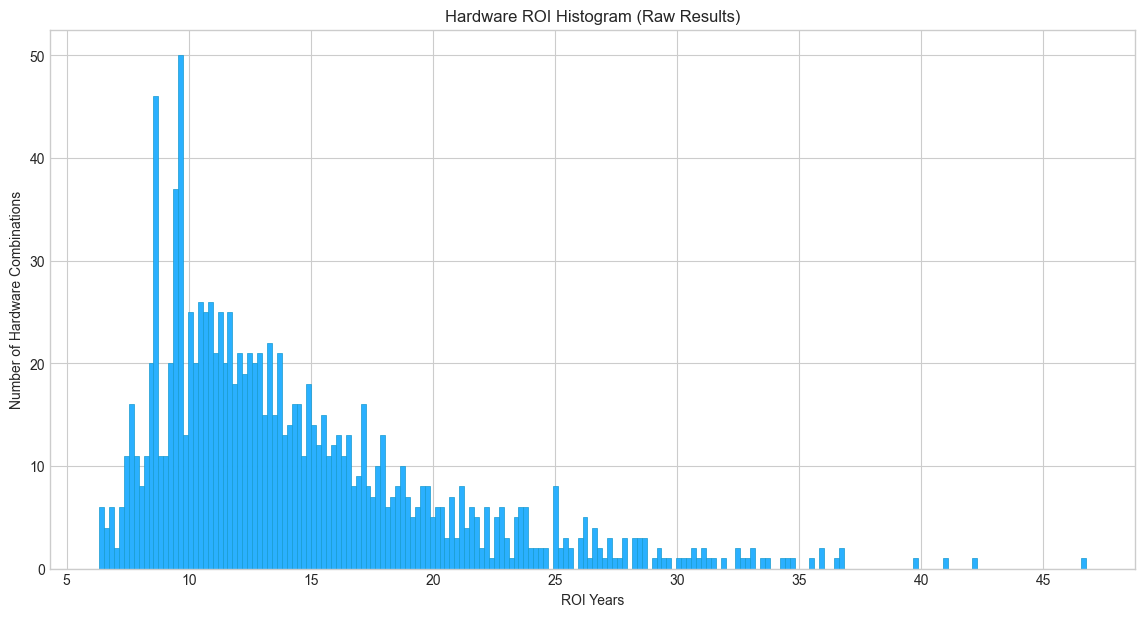

In [307]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(results_df['realRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware ROI Histogram (Raw Results)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

## Filtering

In [308]:
#filter out anything with an ROI over its working years
favROI_df = results_df[results_df['realRoi'] <= results_df['workingLife']] 

print(str(favROI_df.shape[0])+ ' total favorable ROI hardware combinations generated')
print(str(favROI_df[favROI_df['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated')
print(str(favROI_df[favROI_df['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated')
print(str(favROI_df[favROI_df['az']==250].shape[0])+ ' westerm favorable ROI hardware combinations generated')

205 total favorable ROI hardware combinations generated
0 eastern favorable ROI hardware combinations generated
205 southern favorable ROI hardware combinations generated
0 westerm favorable ROI hardware combinations generated


In [309]:
#these should all match when inflation and degrade rates are set to 0
#p = 0
# print(favROI_df.iloc[p][['annualPVkWh','annualPVkWh_degraded']])
# print(favROI_df.iloc[p][['annualPVkWhAC','annualPVkWhAC_degraded']])
# print(favROI_df.iloc[p][['maxAutoParticipationMonthlyW','maxAutoParticipationMonthlyW_degraded']])
# print(favROI_df.iloc[p][['drIncMonthly','drIncMonthly_degraded']])
# print(favROI_df.iloc[p][['annualIncome','annualIncome_degInf']])

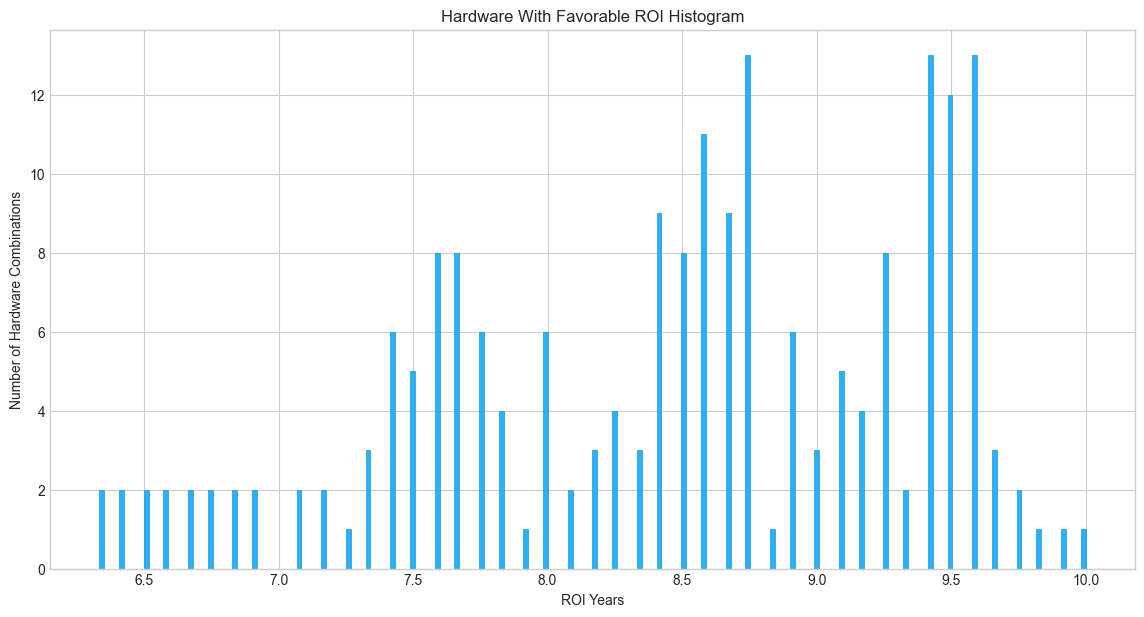

In [310]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['realRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

# Analysis

To analize:
* impact of network characteristics
* time and overall quantity
* relationship between azimuth and time

## Overall

* Fastest ROI
* Greatest IAR
* Greatest DR impact
* Greatest PV generation DC
* Greatest avoided grid energy

In [311]:
# fastest ROI
fRoi = favROI_df[favROI_df['realRoi'] == min(favROI_df['realRoi'])]
print("Fastest ROI: " + str(fRoi['realRoi'].iloc[0]) + "yrs")
# slowest ROI
sRoi = favROI_df[favROI_df['realRoi'] == max(favROI_df['realRoi'])]
print("Slowest ROI: " + str(sRoi['realRoi'].iloc[0]) + "yrs")


Fastest ROI: 6.333333333333333yrs
Slowest ROI: 10.0yrs


Greatest IAR: $687.9914784612467 ($71.74768275381574/per year for 9.58904109589041 years)
Lowest IAR: $0.0 ($0.0/per year for 9.58904109589041 years)
Amount with 0 IAR: 11


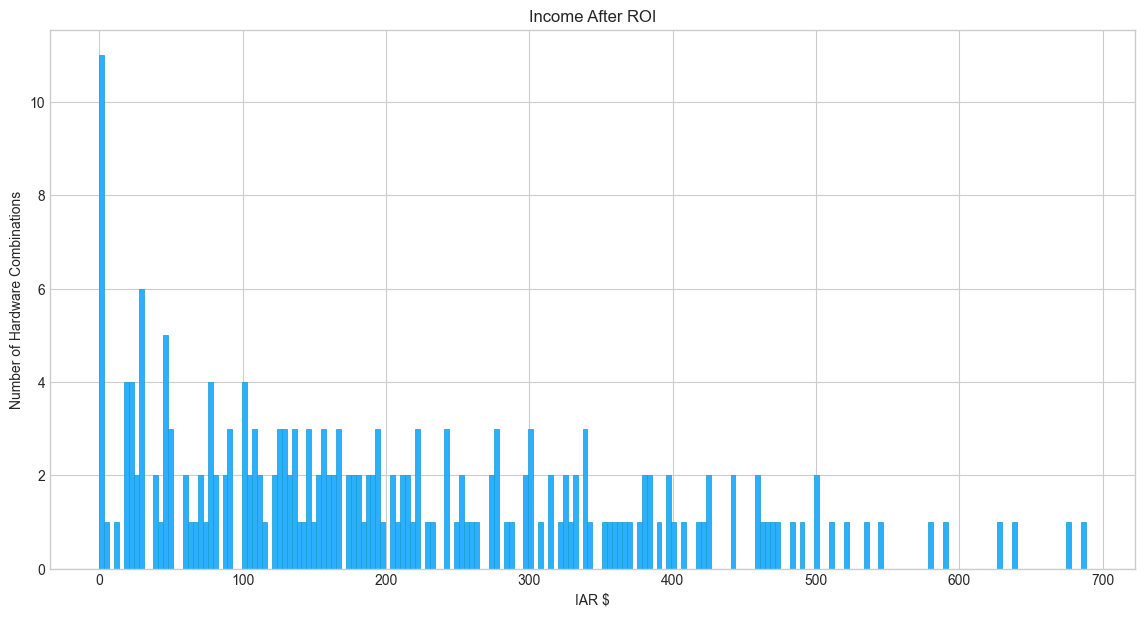

In [312]:
# Income After ROI
maxIAR = favROI_df[favROI_df['incomeAfterRoi'] == max(favROI_df['incomeAfterRoi'])]
print("Greatest IAR: $" + str(maxIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

minIAR = favROI_df[favROI_df['incomeAfterRoi'] == min(favROI_df['incomeAfterRoi'])]
print("Lowest IAR: $" + str(minIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

print('Amount with 0 IAR: ' + str(favROI_df[favROI_df['incomeAfterRoi'] == 0].shape[0]))
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Income After ROI') 
plt.xlabel('IAR $') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware w/ IAR >= $300'}, xlabel='batWh', ylabel='pvW'>

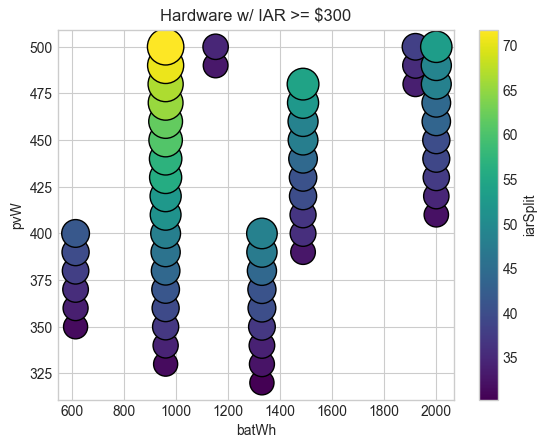

In [313]:
# High IAR

highIAR = favROI_df[favROI_df['incomeAfterRoi'] >= 300]

highIAR.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware w/ IAR >= $300')

# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(highIAR['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Income After ROI ($0 IAR not shown)') 
# plt.xlabel('IAR $') 
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

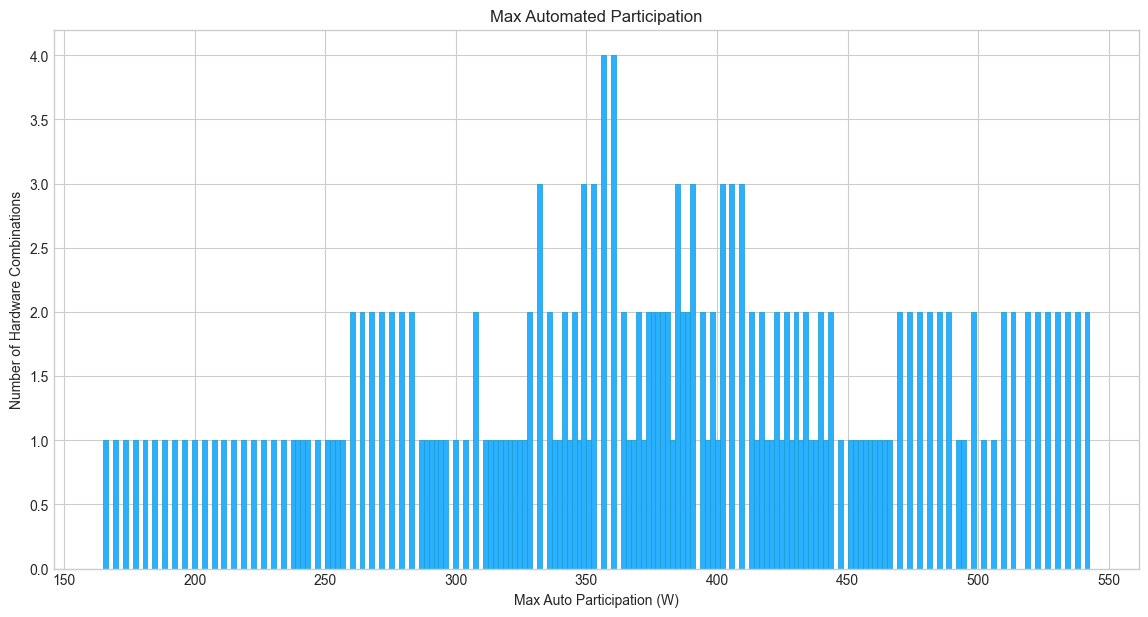

In [316]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['avgMAPw'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Max Automated Participation') 
plt.xlabel('Max Auto Participation (W)') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

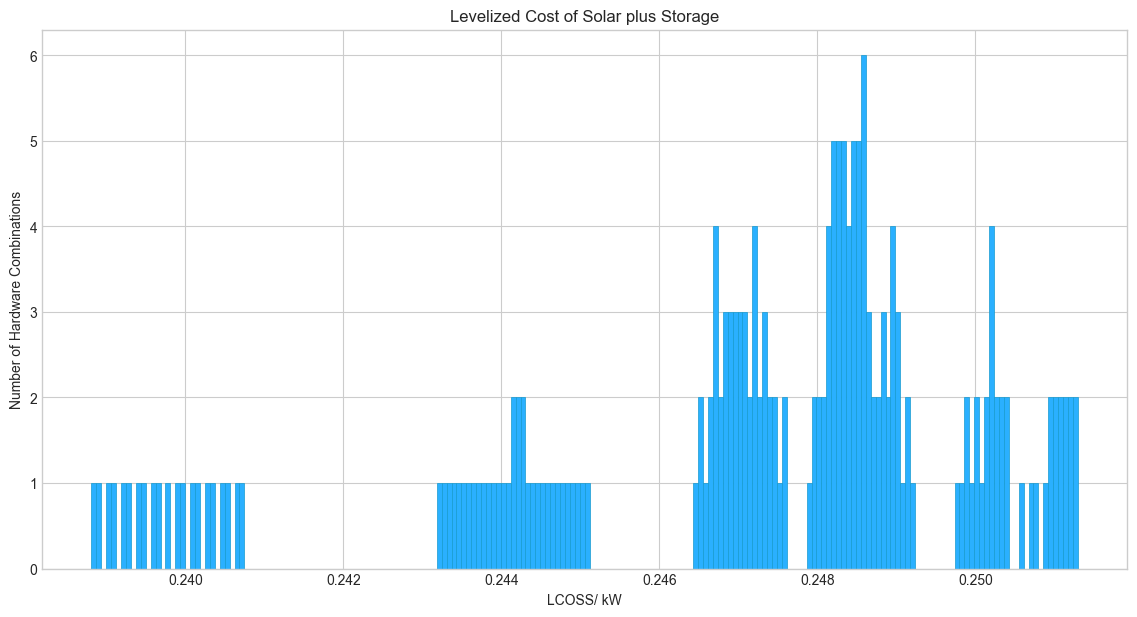

In [333]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['LCOSS'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Levelized Cost of Solar plus Storage') 
plt.xlabel('LCOSS/ kW') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

## Impact of Network Characteristics

Below this point, only favorable ROI combinations are considered.

<AxesSubplot:title={'center':'Max Auto Participation'}, xlabel='realRoi', ylabel='eventStart'>

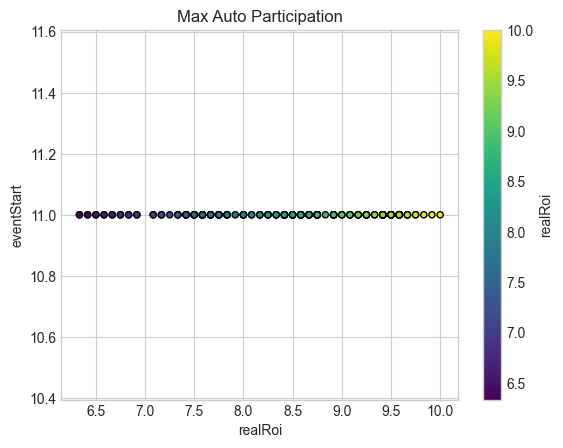

In [314]:
favROI_df.plot(kind = 'scatter', x = 'realRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation')


In [315]:
#build a data frame with characteristics by neighborhood

#regardless of azimuth
nFavorable = {
    "name":[],
    "total amount":[],
    "start time":[],
    "dr rate $":[],
    "min PV":[],
    "min PV bat Wh":[], #the battery that pairs with the min PV module
    "max PV":[],
    "max PV bat Wh":[], #the battery that pairs with the max PV module
    "min bat":[],
    "min bat PV W":[], #the PV modules that pair with the min battery
    "max bat":[],
    "max bat PV W":[], #the PV modules that pair with the max battery
    "min capex":[],
    "max capex":[],
    #avg capex is kind of meaningless,
    #because lower call times have both cheaper and most expensive system,
    #so just a wider range of possibilities
    "avg capex":[], 
    "min ROI":[],
    "max ROI":[],
    "avg ROI":[],
    "min IAR":[],
    "max IAR":[],
    "avg IAR":[],
    "min DR":[],
    "max DR":[],
    "avg DR":[]
}
for n in myNetworks:
    tNAz = favROI_df[favROI_df['network'] == n]
    tN = tNAz#[tNAz['az'] == 180] #uncomment to filter by azimuth
    nFavorable['name'].append(n)
    
    nFavorable['start time'].append(getStartTime(n))
    nFavorable['dr rate $'].append(getTotalRate(n))
    
    if tN.shape[0] != 0:
        nFavorable['total amount'].append(tN.shape[0])
    
        #min PV
        tNminMax = tN[tN['pvW'] == min(tN['pvW'])]
        nFavorable['min PV'].append(min(tN['pvW']))
        nFavorable['min PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #max PV
        tNminMax = tN[tN['pvW'] == max(tN['pvW'])]
        nFavorable['max PV'].append(max(tN['pvW']))
        nFavorable['max PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #min BAT
        tNminMax = tN[tN['batWh'] == min(tN['batWh'])]
        nFavorable['min bat'].append(min(tN['batWh']))
        nFavorable['min bat PV W'].append(list(set(tNminMax['pvW'])))

        #max BAT
        tNminMax = tN[tN['batWh'] == max(tN['batWh'])]
        nFavorable['max bat'].append(max(tN['batWh']))
        nFavorable['max bat PV W'].append(list(set(tNminMax['pvW'])))

        nFavorable['min capex'].append(min(tN['capex']))
        nFavorable['max capex'].append(max(tN['capex']))
        nFavorable['avg capex'].append(tN['capex'].mean())
        nFavorable['min ROI'].append(min(tN['realRoi']))
        nFavorable['max ROI'].append(max(tN['realRoi']))
        nFavorable['avg ROI'].append(tN['realRoi'].mean())
        
        nFavorable['min IAR'].append(min(tN['incomeAfterRoi']))
        nFavorable['max IAR'].append(max(tN['incomeAfterRoi']))
        nFavorable['avg IAR'].append(tN['incomeAfterRoi'].mean())

        mDR = []
        for y in tN['maxAutoParticipationW_degraded']:
            mDR.append(sum(y)/len(y))

        nFavorable['min DR'].append(min(mDR))
        nFavorable['max DR'].append(max(mDR))
        nFavorable['avg DR'].append(sum(mDR)/len(mDR))
    else:
        for k in ['total amount','min PV','min PV bat Wh','max PV','max PV bat Wh',
                  'min bat','min bat PV W','max bat','max bat PV W',
                  'min capex','max capex','avg capex','min ROI','max ROI',
                  'avg ROI','min IAR','max IAR','avg IAR','min DR','max DR','avg DR']:
            nFavorable[k].append(0)

networkResults_df = pd.DataFrame.from_dict(nFavorable)
networkResults_df

,name,total amount,start time,dr rate $,min PV,min PV bat Wh,max PV,max PV bat Wh,min bat,min bat PV W,...,avg capex,min ROI,max ROI,avg ROI,min IAR,max IAR,avg IAR,min DR,max DR,avg DR
0,city hall,205,11,36,200,"[960.0, 1330.0, 614.0]",500,"[1536.0, 1152.0, 1920.0, 1440.0, 960.0, 680.96...",614.0,"[260, 390, 270, 400, 280, 290, 300, 310, 320, ...",...,1373.861228,6.333333,10.0,8.455691,0.0,687.991478,209.590852,164.917321,542.63326,371.683494


In [317]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

# bPD = favROI_df[favROI_df['az'] == 250]
    
# boxPlotData = {}
# for n in myNetworks:
#     bP = bPD[bPD['network'] == n]
#     #print(bP['maxAutoParticipationW'].head())
#     #the full label thing doesn't work when some results are 0
#     #print(type(list(bP['maxAutoParticipationW'])))
#     boxPlotData[n]=bP['maxAutoParticipationW']# + "\n("+ str(bP.iloc[0]['eventStart']) + ", $" + str(bP.iloc[0]['totalDRratekW']) +")"]=bP['maxAutoParticipationW']

# boxPlot_df = pd.DataFrame.from_dict(boxPlotData)
# boxPlot_df.boxplot(figsize=(14,7))

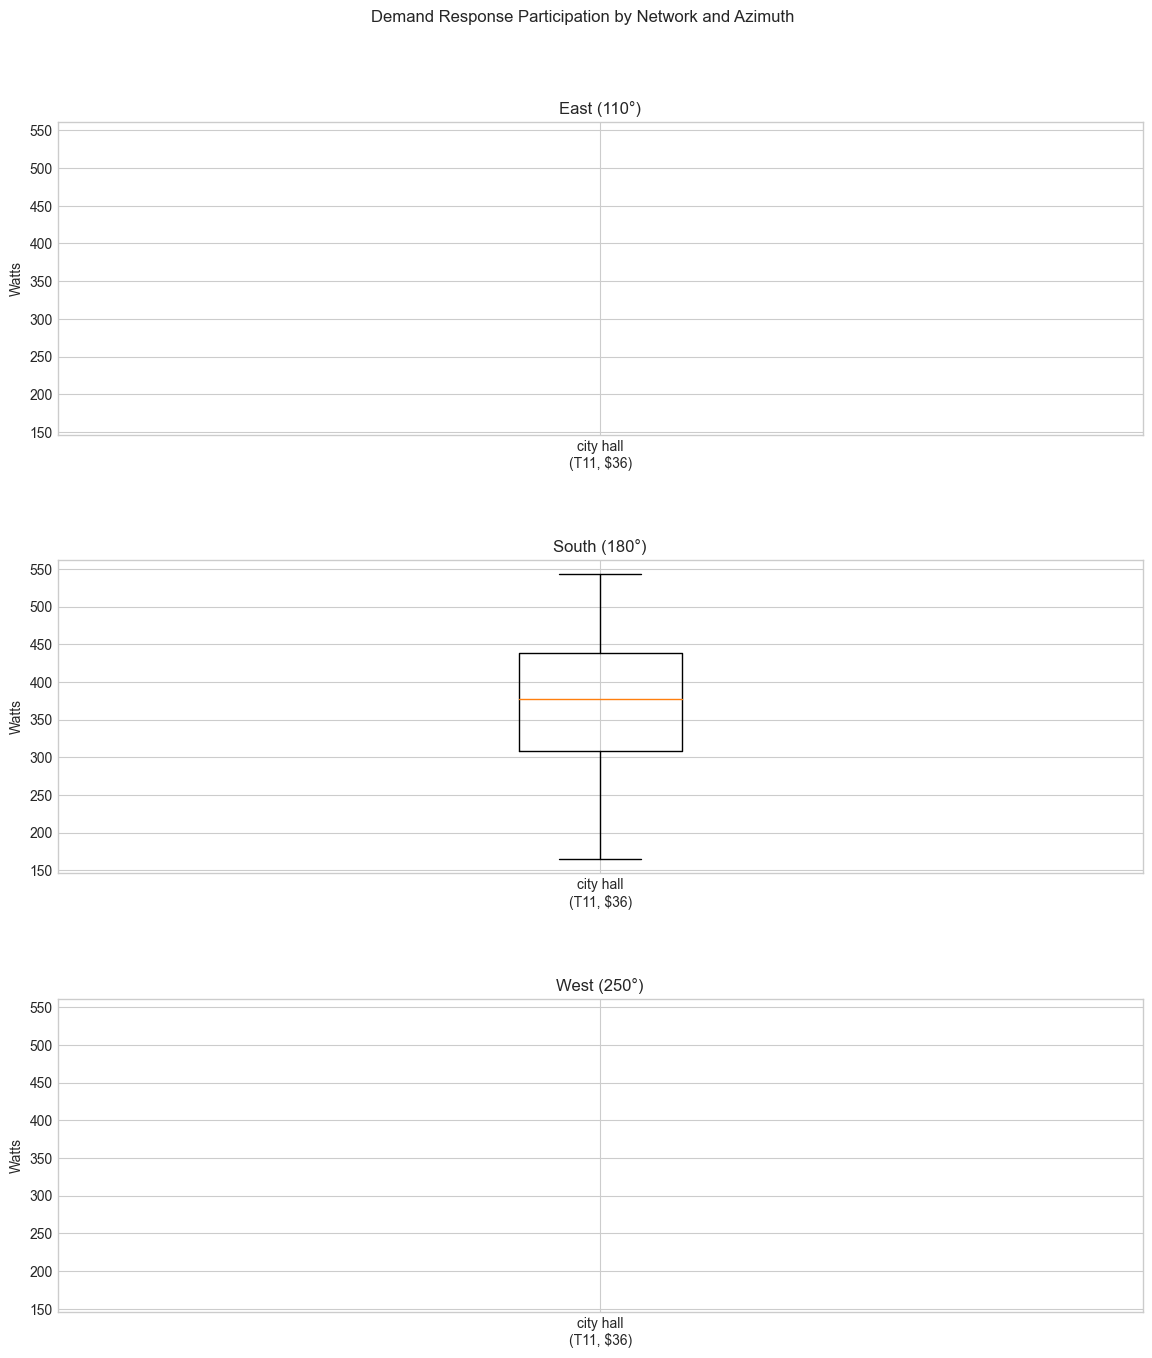

In [319]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df[favROI_df['az'] == 180][favROI_df[favROI_df['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df[favROI_df['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('Demand Response Participation by Network and Azimuth')
    
plt.show()


<AxesSubplot:title={'center':'Max Auto Participation'}, xlabel='avgMAPw', ylabel='eventStart'>

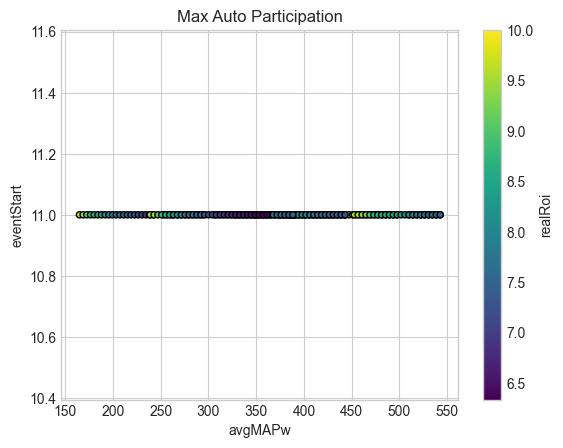

In [320]:
favROI_df.plot(kind = 'scatter', x = 'avgMAPw', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation')


<AxesSubplot:title={'center':'Income After ROI'}, xlabel='incomeAfterRoi', ylabel='eventStart'>

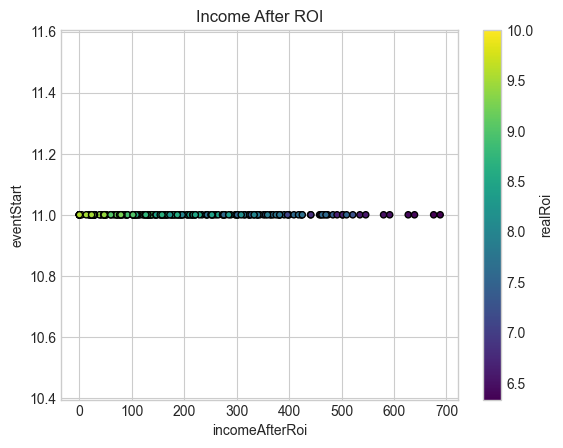

In [321]:
favROI_df.plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Income After ROI')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

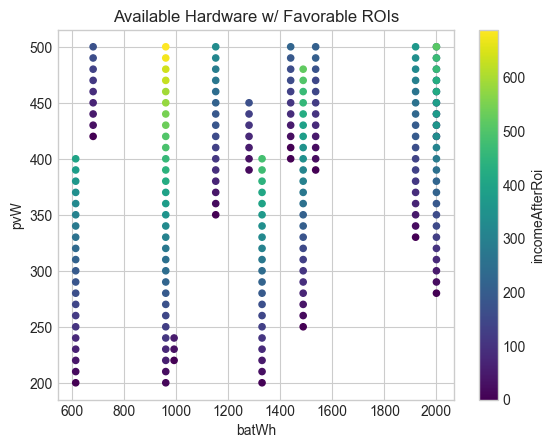

In [322]:
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs & high IAR'}, xlabel='batWh', ylabel='pvW'>

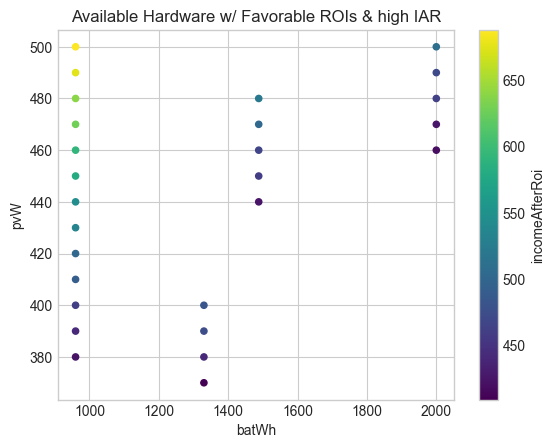

In [323]:
favROI_df[favROI_df['incomeAfterRoi']>=400].plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs & high IAR')


<AxesSubplot:title={'center':'Relationship between IAR and DR Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw'>

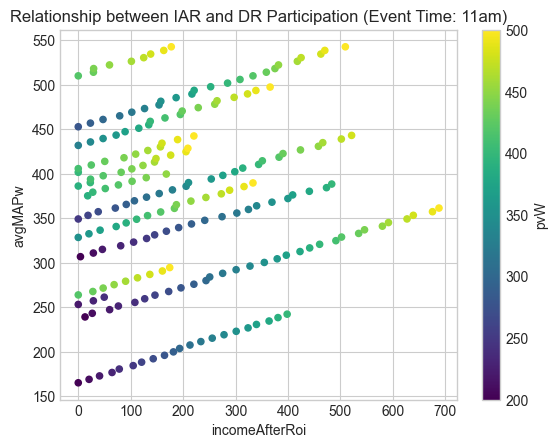

In [325]:
favROI_df[favROI_df['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw', c='pvW',colormap='viridis', title='Relationship between IAR and DR Participation (Event Time: 11am)')


In [326]:
highParticipation_df = favROI_df[favROI_df['avgMAPw']>=400]
highParticipation_df.shape[0]

80

<AxesSubplot:title={'center':'Max Auto Participation > 400W'}, xlabel='avgMAPw', ylabel='eventStart'>

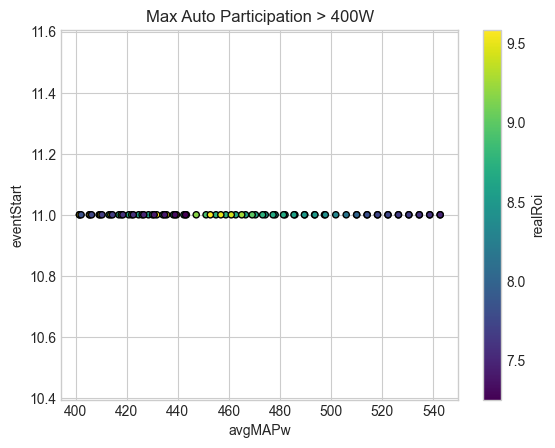

In [327]:
highParticipation_df.plot(kind = 'scatter', x = 'avgMAPw', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Max Auto Participation > 400W')


<AxesSubplot:title={'center':'Available Hardware w/ DR Impact > 400W'}, xlabel='batWh', ylabel='pvW'>

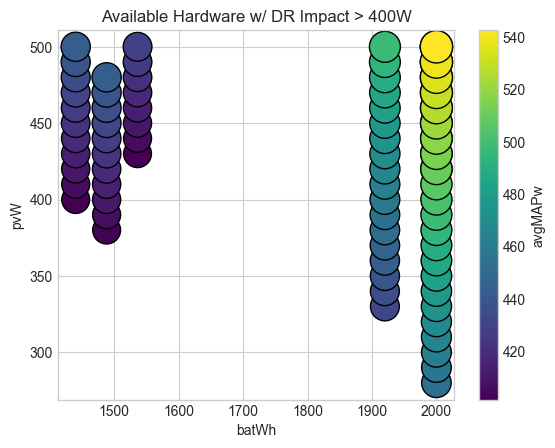

In [329]:
highParticipation_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='avgMAPw',s='avgMAPw',edgecolor='black',colormap='viridis', title='Available Hardware w/ DR Impact > 400W')


## Loads


### Typical Appliances

#### Fixed
* Refrigerator

#### Behavior Dependent
Note that baselines are determined by X, so random loads that aren't used at generally the same time each day wouldn't be considered.
* AC
* Fan
* Lamp
* Overhead lights
* Computer
* Electric Stove
* Convection stove

In [161]:
# Typical refrigerator
# source: https://www.energysage.com/electricity/house-watts/how-many-watts-does-a-refrigerator-use/#:~:text=A%20home%20refrigerator's%20power%20consumption,amps%20and%20about%20120%20volts.
fridgeDutyCycle = .333

fridgeMaxW = 800 * fridgeDutyCycle
fridgeMinW = 300 * fridgeDutyCycle
print('Fridge Watts')
print('Max: ' + str(fridgeMaxW) + 'W (' + str(fridgeMaxW * 24) + ' Wh/day)')
print('Min: ' + str(fridgeMinW) + 'W (' + str(fridgeMinW * 24) + ' Wh/day)')


Fridge Watts
Max: 266.40000000000003W (6393.6 Wh/day)
Min: 99.9W (2397.6000000000004 Wh/day)


## Final Analysis

Compare to Nest thermostat